In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from pandas import Series, DataFrame
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.core.pylabtools import figsize
from IPython.display import display

SAVE_FIG = True

if SAVE_FIG:
    from matplotlib import rcParams  
    rcParams['axes.labelsize'] = 9  
    rcParams['xtick.labelsize'] = 9  
    rcParams['ytick.labelsize'] = 9  
    rcParams['legend.fontsize'] = 9 
    default_fig_w = 8
    default_fig_h = 5
else:
    default_fig_w = 16
    default_fig_h = 10

%matplotlib inline
figsize(default_fig_w, default_fig_h)

# Load and adjust the data

In [2]:
df_train = pd.read_csv('../data/TableS2_training.csv', keep_default_na=False)
df_train['RRF_Measured'] = df_train['RRF_Measured'] * 1e-2
df_train['RRF_Predicted'] = df_train['RRF_Predicted'] * 1e-2

df_test = pd.read_csv('../data/TableS3_training.csv', keep_default_na=False)
df_test['RRF_Measured'] = df_test['RRF_Measured'] * 1e-2
df_test['RRF_Predicted'] = df_test['RRF_Predicted'] * 1e-2

features = ['MV', 'logD', 'abs_mob']
target = ['RRF_Measured']

# Data preparation
- Exclude certain metabolites
- Select training and testing data

In [3]:
# Training Data
X_train = df_train[features]
X_train = X_train[df_train['Annotation'] == '']

y_train = df_train[target]
y_train = y_train[df_train['Annotation'] == '']

# Testing Data
X_test = df_test[features]
y_test = df_test[target]

print("Number of metabolites (training):", len(X_train))
print("Number of metabolites (testing):", len(X_test))

Number of metabolites (training): 36
Number of metabolites (testing): 10


# Fit Gaussian Process

In [4]:
model = GPy.models.GPRegression(X_train, y_train, normalizer=True)

model.optimize()

display(model)

# Make predictions

In [5]:
mu, var = model.predict(X_test.as_matrix())
s = np.sqrt(var)

In [6]:
data_test = pd.concat([
        df_test, 
        DataFrame({'RRF_Predicted_New': mu.flatten(), 'RRF_Predicted_Std_New': s.flatten()})], axis=1)

data_test[['Name', 'RRF_Measured', 'RRF_Predicted', 'RRF_Predicted_New', 'RRF_Predicted_Std_New']]

,Name,RRF_Measured,RRF_Predicted,RRF_Predicted_New,RRF_Predicted_Std_New
0,L-Ornithine,0.00281,0.00631,0.006826,0.006965
1,N-Methyl-Aspartic acid,0.00842,0.00667,0.008051,0.006826
2,3-Methyl-L-Histidine,0.01400,0.02280,0.021092,0.006791
3,L-Theanine,0.02320,0.02190,0.023411,0.006807
4,L-Citrulline,0.01160,0.01600,0.019378,0.006795
5,O-Propionyl-L-Carnitine,0.05230,0.05740,0.046295,0.008042
6,L-Carnosine,0.01910,0.03030,0.030535,0.007115
7,O-Butyryl-L-Carnitine,0.06660,0.06030,0.065164,0.008666
8,1-Methyl-Adenosine,0.05240,0.05110,0.058979,0.008567
9,O-Octoyl-L-Carnitine,0.07780,0.09750,0.085108,0.032453


# Comparison of model metrics

In [7]:
from sklearn import linear_model

regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
y_true = data_test['RRF_Measured']
y_pred = data_test['RRF_Predicted']
y_pred_lin = regr.predict(X_test)
y_pred_new = data_test['RRF_Predicted_New']

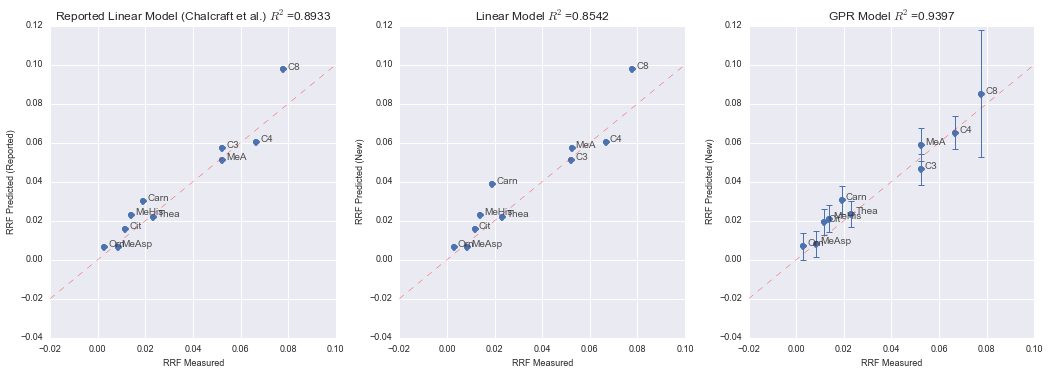

In [9]:
figsize(1.8 * default_fig_w, default_fig_h)

ax = plt.subplot(1, 3, 1)
plt.xlabel('RRF Measured')
plt.ylabel('RRF Predicted (Reported)')
plt.scatter(y_true, y_pred)
plt.errorbar(y_true, y_pred, fmt='o', elinewidth=1, capthick=1, capsize=3, mew=0)

xlim = plt.xlim()
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)

for x, y, label in zip(y_true, y_pred, df_test.ix[X_test.index]['Short Name']):
    ann = ax.annotate(label, (x + 0.002, y), alpha=0.8)

ylim = plt.ylim()

plt.title('Reported Linear Model (Chalcraft et al.) $R^2$={:.4f}'.format(r2_score(y_true, y_pred)))
#---

ax = plt.subplot(1, 3, 2)
plt.xlabel('RRF Measured')
plt.ylabel('RRF Predicted (New)')
plt.scatter(y_true, y_pred_lin)
plt.errorbar(y_true, y_pred_lin, fmt='o', elinewidth=1, capthick=1, capsize=3, mew=0)

xlim = plt.xlim()
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)

for x, y, label in zip(y_true, y_pred_lin, df_test.ix[X_test.index]['Short Name']):
    ann = ax.annotate(label, (x + 0.002, y), alpha=0.8)

ylim = plt.ylim()

plt.title('Linear Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred_lin)))
#---

ax = plt.subplot(1, 3, 3)
plt.xlabel('RRF Measured')
plt.ylabel('RRF Predicted (New)')
plt.scatter(y_true, y_pred_new)
plt.errorbar(y_true, y_pred_new, yerr=np.sqrt(var), fmt='o', elinewidth=1, capthick=1, capsize=3)

plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)
plt.ylim(*ylim)

for x, y, label in zip(y_true, y_pred_new, df_test.ix[X_test.index]['Short Name']):
    ann = ax.annotate(label, (x + 0.002, y), alpha=0.8)

plt.grid(True)
plt.title('GPR Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred_new)))

plt.tight_layout(pad=0.1)

if SAVE_FIG:
    plt.savefig('../figures/linear_and_gp_regression.pdf')

plt.show()

## Metrics of the model reported in the paper

In [10]:
print("mean_squared_error", mean_squared_error(y_true, y_pred))
print("r2_score", r2_score(y_true, y_pred))

mean_squared_error 6.947225e-05
r2_score 0.893256890472


## Metrics of our new models

In [11]:
print("Linear")
print("mean_squared_error", mean_squared_error(y_true, y_pred_lin))
print("r2_score", r2_score(y_true, y_pred_lin))

print()
print("GP")
print("mean_squared_error", mean_squared_error(y_true, y_pred_new))
print("r2_score", r2_score(y_true, y_pred_new))
print("Log Likeliehood", np.sum([norm.logpdf(t[0], loc=t[1], scale=t[2]) for t in zip(y_true, y_pred_new, data_test['RRF_Predicted_Std_New'])]))

Linear
mean_squared_error 9.48819498111e-05
r2_score 0.854215253415

GP
mean_squared_error 3.92663253373e-05
r2_score 0.939667857796
Log Likeliehood 35.1699923149
